In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline


In [5]:
words = open('names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
def stoi_itos(words):
    vocab = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(vocab)}
    stoi['.']  = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos, len(words)


# Build Dataset
- read the names from the names.txt
- find the vocab or character in the name.txt file
- Chose the block-size and make example dataset from the names
- X: input to the model
- Y: output by the model during traing

In [33]:
import random
def build_dataset(file_path='names.txt', context_len = 3):
    words = open('names.txt').read().splitlines()
    random.shuffle(words)
    stoi,itos,vocab_size  = stoi_itos(words)
    X = []
    Y = []
    blocks_size  = context_len
    for w in words:
        
        context= [0]*blocks_size
        
        for char in w + '.': 
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            # print(''.join([ itos[char] for char in context]), '---> ', itos[ix])
            # print(context)
            context = context[1:] + [ix]
            # print(context)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    x1 = int(0.8*len(words))
    x2 = int(0.9*len(words))
    
    dataset ={'train': [X[0:x1] , Y[0:x1]], 'val': [X[x1:x2], Y[x1:x2]], 'test': [X[x2:], Y[x2:]]}
    return dataset


    

In [34]:
dataset = build_dataset(words)


# Initialize the Model
- initialize the generator using torch.Generator().manual_seed(number)
- Initialize the the embedding matrix C
- 

In [35]:
def initialize_model(vocab_size, emb_dim,Input_data, layers_dim = []):
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((vocab_size,emb_dim), generator=g)
    W1 = torch.randn((Input_data.shape[1]*emb_dim, layers_dim[0] ), generator=g)
    # print(W1.shape)
    b1 = torch.randn(layers_dim[0], generator=g)
    
    W2 = torch.randn((layers_dim[0],vocab_size), generator=g)
    b2 = torch.randn(vocab_size, generator=g)
    
    parameters = [C, W1,b1, W2,b2]
    return parameters

In [36]:
def model(X, parameters):
    emb = parameters[0][X]
    a1 = torch.tanh(emb.view(-1,30)  @ parameters[1] + parameters[2])
    logits = a1 @ parameters[3] + parameters[4]
    return logits

In [37]:
def requires_grad(parameters):
    for p in parameters:
        p.requires_grad = True
    return parameters

In [39]:
import random
context_len = 3
data_path = 'names.txt'
vocab_size = 27
emb_dim=10
layers_dim = [300,27]
epochs = 90000
dataset = build_dataset(words)
Xtr,Ytr = dataset['train']
Xval, Yval = dataset['val']
Xtest, Ytest = dataset['test']
# num_examples = len(X)
# Xtr,Xval,Xtest = X[0:int(0.7*num_examples)], X[int(0.7*num_examples):int(0.9*num_examples)], X[int(0.9*num_examples): num_examples]
# Ytr,Yval,Ytest = Y[0:int(0.7*num_examples)], Y[int(0.7*num_examples):int(0.9*num_examples)], Y[int(0.9*num_examples): num_examples]

# print(Xtr.shape, Ytr.shape)
parameters = initialize_model(vocab_size, emb_dim, Xtr, layers_dim = layers_dim)
parameters = requires_grad(parameters)
# print(X.shape)
# print(Y.shape)

lre = torch.linspace(-3,0, epochs)
lrr = 10**lre

#Forward Pass
lri = []
lossi = []
stepi = []
for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # print(Xtr[ix].shape)
    logits = model(Xtr[ix], parameters)
    # print(logits.shape)
    # Calculate Loss
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    
    # calculate the gradients
    loss.backward()
    
    #Gradient Descent
    lr = [0.1,0.01]
    if i<=30000:
        lr = lr[0]
    else:
        lr = lr[1]
    for p in parameters:
        p.data += -lr*p.grad
    lossi.append(loss.log10().item())
    lri.append(lr)
    stepi.append(i)
print(loss.item())


2.0284738540649414


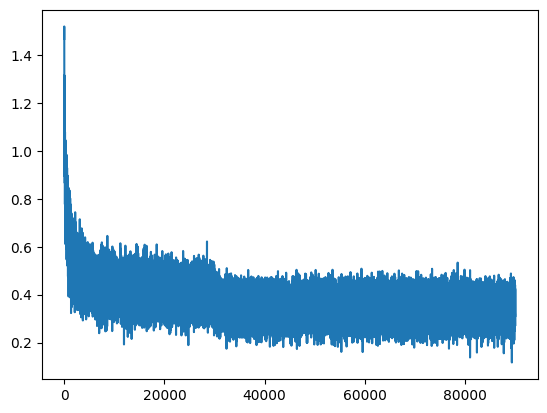

In [102]:
plt.plot(stepi, lossi)

In [103]:
logits = model(Xtr, parameters)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.2177610397338867

In [104]:
logits = model(Xval, parameters)
loss = F.cross_entropy(logits, Yval)
loss.item()

2.259831428527832

In [105]:
logits = model(Xtest, parameters)
loss = F.cross_entropy(logits, Ytest)
loss.item()

2.2593190670013428

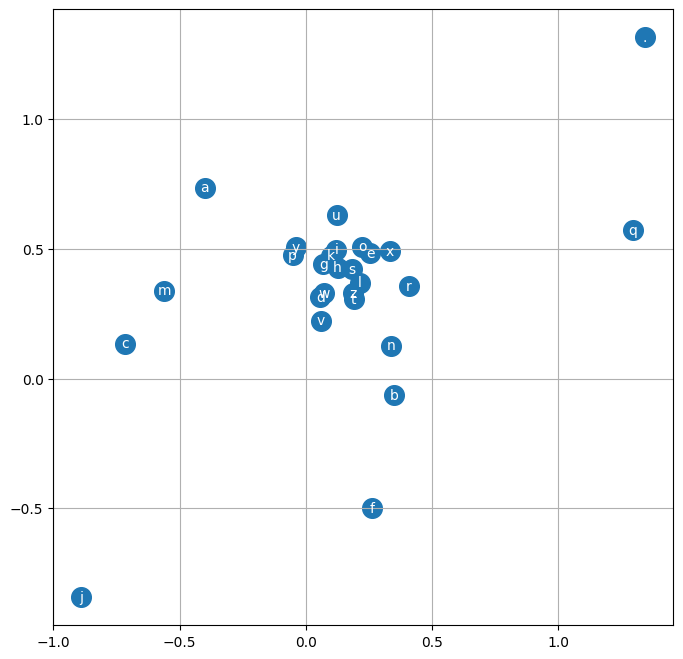

In [106]:
# This code was effect for the emb_dim=2
# # plt.figure()
# plt.figure(figsize=(8,8))
# plt.scatter(parameters[0][:,0].data, parameters[0][:,1].data, s=200)
# for i in range(parameters[0].shape[0]):
#     plt.text(parameters[0][i,0].item(), parameters[0][i,1].item(), itos[i], ha='center', va='center', color='white')
# plt.grid('minor')

In [110]:
import torch
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    ix = 0
    out = []
    block_size = 3
    context = [0] * block_size 
    while True:
        emb = parameters[0][torch.tensor([context])]
        a1 = torch.tanh(emb.view(-1,30) @ parameters[1] + parameters[2])
        logits = a1 @ parameters[3] + parameters[4]
        probs = F.softmax(logits ,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))

junide.
jakaliz.
paliah.
adni.
koith.
tolian.
juzt.
kalinaa.
zamileniav.
dedainr.
imellsianiely.
arten.
nomanthif.
deumpin.
nishana.
jazi.
core.
yaenon.
jaevandin.
jamiil.
wynin.
anaasnasvilionszoradion.
matiani.
zir.
pann.
that.
jayreri.
isa.
fyni.
miek.
jemahvussian.
kha.
coarr.
jenh.
adarta.
malyn.
jalyhi.
iveavaroni.
themiraya.
athu.
phels.
tavisitikiesaloe.
marnishaw.
fabilleer.
anten.
chan.
jazeodriccojornialiya.
rann.
tezriellia.
vymiee.
